## NIPA 하반기 경진대회 예선

## Settings


In [2]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/인공지능 학습관련/NIPA_하반기 경진대회_사전검증
!pwd

/content/drive/My Drive/인공지능 학습관련/NIPA_하반기 경진대회_사전검증
/content/drive/My Drive/인공지능 학습관련/NIPA_하반기 경진대회_사전검증


## Data


In [9]:
df = pd.read_csv('./train/train.tsv', sep='\t', header=None)
df.columns = ['file_name','plant','disease']
df

,file_name,plant,disease
0,3_5_1123.jpg,3,5
1,3_20_1048.jpg,3,20
2,4_2_401.jpg,4,2
3,4_7_740.jpg,4,7
4,4_11_93.jpg,4,11
...,...,...,...
15995,13_15_1600.jpg,13,15
15996,13_16_1570.jpg,13,16
15997,13_17_986.jpg,13,17
15998,13_18_4980.jpg,13,18


In [10]:
df['comb_label'] = [str(a)+'_'+str(b) for a,b in zip(df.plant,df.disease)]
df

,file_name,plant,disease,comb_label
0,3_5_1123.jpg,3,5,3_5
1,3_20_1048.jpg,3,20,3_20
2,4_2_401.jpg,4,2,4_2
3,4_7_740.jpg,4,7,4_7
4,4_11_93.jpg,4,11,4_11
...,...,...,...,...
15995,13_15_1600.jpg,13,15,13_15
15996,13_16_1570.jpg,13,16,13_16
15997,13_17_986.jpg,13,17,13_17
15998,13_18_4980.jpg,13,18,13_18


In [11]:
comb_label_sr = df.comb_label.value_counts().sort_index()
comb_label_sr

10_20    800
11_14    800
13_1     800
13_15    800
13_16    800
13_17    800
13_18    800
13_20    800
13_6     800
13_9     800
3_20     800
3_5      800
4_11     800
4_2      800
4_7      800
5_8      800
7_1      800
7_20     800
8_6      800
8_9      800
Name: comb_label, dtype: int64

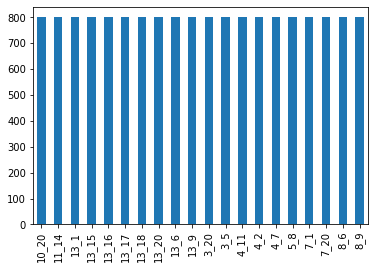

In [12]:
comb_label_sr.plot.bar(x = 'index', rot = 90)

## Labeling the train set


In [13]:
# Make model == feature model
feature_model = keras.applications.DenseNet201(weights="imagenet", include_top=False)

74842112/74836368 [==============================] - 1s 0us/step


In [14]:
feature_model.trainable= False

In [15]:
feature_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [16]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224
batch_size = 1

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory = './train/train_comb',
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = train_datagen.flow_from_directory(directory = './train/train_comb',
                                                    subset = 'validation',
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))
print(train_generator.n)
print(valid_generator.n)

Found 12800 images belonging to 20 classes.
Found 3200 images belonging to 20 classes.
12800
3200


In [ ]:
train_generator.class_indices

{'10_20': 0,
 '11_14': 1,
 '13_1': 2,
 '13_15': 3,
 '13_16': 4,
 '13_17': 5,
 '13_18': 6,
 '13_20': 7,
 '13_6': 8,
 '13_9': 9,
 '3_20': 10,
 '3_5': 11,
 '4_11': 12,
 '4_2': 13,
 '4_7': 14,
 '5_8': 15,
 '7_1': 16,
 '7_20': 17,
 '8_6': 18,
 '8_9': 19}

In [ ]:
train_generator.reset()

## Feature extracting

In [17]:
import numpy as np
from tqdm import tqdm

train_features = []
train_Y = []

# 처음 array

for idx in tqdm(range(train_generator.n)):

    x, y = train_generator.next()
    train_Y.extend(y)

    feature = feature_model.predict(x)
    train_features.extend(feature)
    
train_Y = np.array(train_Y)
train_features = np.array(train_features)

#array 전환 NasNet은 안됨
print(train_features.shape)
print(train_Y.shape)

100%|██████████| 12800/12800 [1:36:19<00:00,  2.21it/s]


(12800, 7, 7, 1920)
(12800, 20)


In [18]:
valid_features = [] 
valid_Y = [] 

for idx in tqdm(range(valid_generator.n)):
    
    x, y = valid_generator.next()   
    valid_Y.extend(y)
  
    feature = feature_model.predict(x)
    valid_features.extend(feature)

#array 전환 NasNet은 안됨
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)


100%|██████████| 3200/3200 [24:56<00:00,  2.14it/s]


(3200, 7, 7, 1920)
(3200, 20)


### Save feature vectors 

In [19]:
np.save('./train_features_Dense.npy',train_features )
np.save('./train_Y_Dense.npy',train_Y )


In [20]:
np.save('./valid_features_Dense.npy',valid_features )
np.save('./valid_Y_Dense.npy',valid_Y )


## Load feature vectors

In [ ]:
train_features = np.load('./train_features_Dense.npy')
train_Y = np.load('./train_Y_Dense.npy')

print("complete train data")


complete train data


In [ ]:
valid_features = np.load('./valid_features_Dense.npy')
valid_Y = np.load('./valid_Y_Dense.npy')

print("complete valid data")

complete valid data


## Classifier


In [21]:
def build_model(feature_model, num_outputs=20):
    
    inputs = Input(shape=feature_model.output.shape[1:])
    
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    
    outputs = Dense(num_outputs, activation='softmax', name='class_disease_output')(x)

    model = Model(inputs=inputs,
                 outputs = outputs)
    
    init_lr = 4e-4
    opt = Adam(lr=init_lr, dacay=1e-6)
    model.compile(optimizer=opt, 
                  loss= 'categorical_crossentropy',
                  metrics='accuracy')
    
    
    return model
# feature_model.output.shape[1:]

In [25]:
model = build_model(feature_model)


model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1920) 0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               491776    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)              

In [26]:
weight_path="./model_best_checkpoint"

cp = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   min_lr=2e-6)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=50) 
callbacks_list = [cp, es, reduceLROnPlat]

In [27]:
initial_epochs = 200

history = model.fit(x = train_features,
                    y = train_Y,
                    validation_data = (valid_features, valid_Y),
                    epochs = initial_epochs,
                    batch_size = 32,
                    callbacks = callbacks_list
                    )

model.summary()

Epoch 1/200
398/400 [============================>.] - ETA: 0s - loss: 2.3602 - accuracy: 0.3240
Epoch 00001: val_accuracy improved from -inf to 0.78812, saving model to ./model_best_checkpoint
400/400 [==============================] - 4s 9ms/step - loss: 2.3577 - accuracy: 0.3248 - val_loss: 0.9548 - val_accuracy: 0.7881
Epoch 2/200
397/400 [============================>.] - ETA: 0s - loss: 1.2679 - accuracy: 0.6064
Epoch 00002: val_accuracy improved from 0.78812 to 0.88750, saving model to ./model_best_checkpoint
400/400 [==============================] - 3s 8ms/step - loss: 1.2653 - accuracy: 0.6073 - val_loss: 0.5119 - val_accuracy: 0.8875
Epoch 3/200
400/400 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.7263
Epoch 00003: val_accuracy improved from 0.88750 to 0.91594, saving model to ./model_best_checkpoint
400/400 [==============================] - 3s 8ms/step - loss: 0.8857 - accuracy: 0.7263 - val_loss: 0.3293 - val_accuracy: 0.9159
Epoch 4/200
397/400

In [28]:
model2 = build_model(feature_model)
# 가중치 로드

model2.load_weights(weight_path)

# 모델 평가
print(model2.evaluate(valid_features, valid_Y))
model2.summary()

100/100 [==============================] - 0s 3ms/step - loss: 0.0840 - accuracy: 0.9825
[0.08396254479885101, 0.9825000166893005]
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 1920) 0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               491776    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               

In [29]:
model2.save('./model_best_Dense.h5')

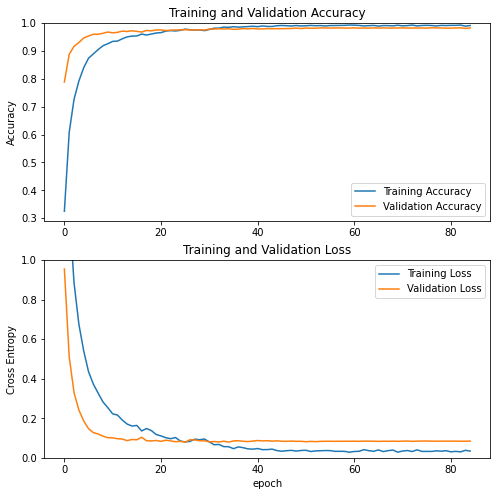

In [30]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [31]:
model3= load_model('./model_best_Dense.h5')
print(model3.evaluate(valid_features, valid_Y))

100/100 [==============================] - 0s 3ms/step - loss: 0.0840 - accuracy: 0.9825
[0.08396254479885101, 0.9825000166893005]


In [35]:
def build_finetuning(model, num_outputs=20):
    
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = feature_model(inputs, training=False)
    outputs = model(x)

    model_fine = Model(inputs=inputs,
                 outputs = outputs)
    init_lr = 1e-5
    opt = Adam(lr=init_lr)
    model_fine.compile(optimizer=opt, 
                    loss= 'categorical_crossentropy',
                    metrics='accuracy')
        
    return model_fine

In [36]:
# finetuning 모델 구축
finetune = build_finetuning(model3)

In [34]:
feature_model.trainable = True

print("Number of layers in the base model: ", len(feature_model.layers))
fine_tune_at = 200

for layer in feature_model.layers[:fine_tune_at]:
    layer.trainable =  False

finetune.summary()

Number of layers in the base model:  707
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
functional_5 (Functional)    (None, 20)                542676    
Total params: 18,864,660
Trainable params: 16,455,508
Non-trainable params: 2,409,152
_________________________________________________________________


In [37]:
weight_path="./DenseNet/model_best_checkpoint"

cp = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   min_lr=1e-7)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [cp, es, reduceLROnPlat]

In [ ]:
fine_tune_epochs = 50

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = finetune.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = total_epochs,
                    steps_per_epoch = train_generator.n//batch_size,
                    validation_steps = valid_generator.n//batch_size,
                    initial_epoch= history.epoch[-1],
                    batch_size = batch_size,
                    callbacks = callbacks_list
                    )

finetune.summary()

Epoch 85/250
 4056/12800 [========>.....................] - ETA: 59:56 - loss: 3.0280 - accuracy: 0.0481

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('DanseNet_graph.jpg')
plt.show()

In [ ]:
model2 = build_finetuning(model3)
# 가중치 로드

model2.load_weights(weight_path)


In [ ]:
finetune.evaluate(valid_generator)

125/125 [==============================] - 51s 404ms/step - loss: 0.0148 - accuracy: 0.9967


[0.014846083708107471, 0.996749997138977]

In [ ]:
model2.save('model_dense_best_tuning.h5')

In [ ]:
finetune.save('model_dense_best2.h5')

### prediction

In [ ]:
model = model2

In [ ]:
test_df = pd.read_csv('./test/test.tsv', sep='\t', header=None)
test_df.columns = ['filepath']
test_df.filepath = "./test/" + test_df.filepath
test_df

,filepath
0,./test/0.jpg
1,./test/1.jpg
2,./test/2.jpg
3,./test/3.jpg
4,./test/4.jpg
...,...
3992,./test/3992.jpg
3993,./test/3993.jpg
3994,./test/3994.jpg
3995,./test/3995.jpg


In [ ]:
print(len(test_df))

3997


In [ ]:
list(train_generator.class_indices.keys())

['10_20',
 '11_14',
 '13_1',
 '13_15',
 '13_16',
 '13_17',
 '13_18',
 '13_20',
 '13_6',
 '13_9',
 '3_20',
 '3_5',
 '4_11',
 '4_2',
 '4_7',
 '5_8',
 '7_1',
 '7_20',
 '8_6',
 '8_9']

In [ ]:
test_filenames = []
comb_pred = []
class_pred = []
disease_pred = []

comb_labels = list(train_generator.class_indices.keys())

for i in tqdm(range(len(test_df))):
    path = test_df.filepath[i]
    filename = path.split('/')[-1]
    test_filenames.append(filename)
    
    img_size = (224,224)
    img = keras.preprocessing.image.load_img(path, target_size=img_size)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    

    prediction = model.predict(img)
    prediction = prediction.argmax()
    prediction = comb_labels[prediction]
    
    c_pred, d_pred = prediction.split('_')
    

    
    class_pred.append(c_pred)
    disease_pred.append(d_pred)
    
    comb_pred.append(prediction)

In [ ]:
# pandas DF로 저장 후 tsv형식으로 저장/ model f1 score검사
import pandas as pd
import numpy as np

df = pd.DataFrame({'filename' : test_filenames, 'plant_class' : class_pred, 'disease_class':disease_pred})
df

,filename,plant_class,disease_class
0,0.jpg,3,5
1,1.jpg,3,20
2,2.jpg,4,2
3,3.jpg,4,7
4,4.jpg,4,11
...,...,...,...
3992,3992.jpg,13,15
3993,3993.jpg,13,16
3994,3994.jpg,13,17
3995,3995.jpg,13,18


In [ ]:
df.to_csv("class_disease_pred6.tsv", mode='w',sep='\t', index=False, header=None)